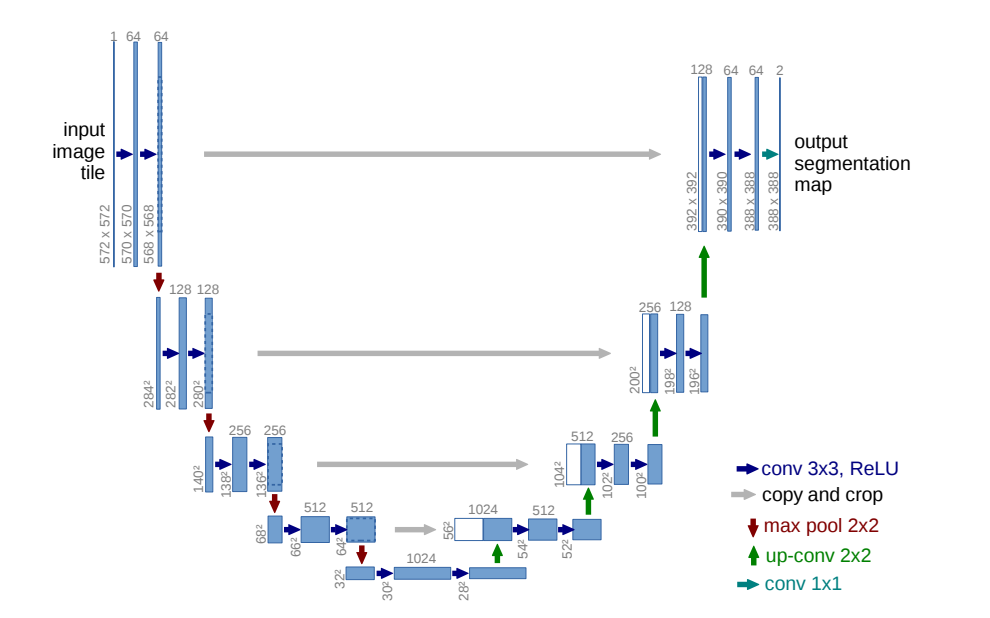

**The network architecture is illustrated above. It consists of a contracting
path (left side) and an expansive path (right side). The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. 
The cropping is necessary due to the loss of border pixels in
every convolution. At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes. In total the network
has 23 convolutional layers.
To allow a seamless tiling of the output segmentation map (see Figure 2), it
is important to select the input tile size such that all 2x2 max-pooling operations
are applied to a layer with an even x- and y-size.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn

In [2]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size = 3),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_c, out_c, kernel_size = 3),
        nn.ReLU(inplace=True)
    )
    
    return conv
    

    
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:,delta:tensor_size-delta, delta:tensor_size-delta]


In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        
        
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels = 1024, 
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        
        self.up_conv_1 = double_conv(1024, 512)
        
         
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels = 512, 
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        
        self.up_conv_2 = double_conv(512, 256) 
        
        
        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels = 256, 
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        
        self.up_conv_3 = double_conv(256, 128)
   

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels = 128, 
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        
        self.up_conv_4 = double_conv(128, 64)

        
        self.out = nn.Conv2d(
            in_channels = 64,
            out_channels = 2,
            kernel_size = 1
        
        )
    
    def forward(self, image):
        # bs, c, h, w
        # encoder
        x1 = self.down_conv_1(image)
        print(x1.size())
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        print(x9.size())
        
        # decoder
        
        x = self.up_trans_1(x9)
        y = crop_img(x7,x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        
        x = self.up_trans_2(x)
        y = crop_img(x5,x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        
        
        x = self.up_trans_3(x)
        y = crop_img(x3,x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        
        
        x = self.up_trans_4(x)
        y = crop_img(x1,x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x = self.out(x)
        print(x.size())
        
        return x
#         print(x7.size())
#         print(y.size())
        
        
        
        
if __name__ == "__main__":
    image = torch.rand(1, 1, 572, 572)
    model = UNet()
    print(model(image))

torch.Size([1, 64, 568, 568])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 2, 388, 388])
tensor([[[[-0.0444, -0.0407, -0.0422,  ..., -0.0476, -0.0432, -0.0399],
          [-0.0433, -0.0439, -0.0419,  ..., -0.0490, -0.0452, -0.0417],
          [-0.0446, -0.0432, -0.0442,  ..., -0.0457, -0.0481, -0.0449],
          ...,
          [-0.0419, -0.0449, -0.0435,  ..., -0.0424, -0.0407, -0.0464],
          [-0.0437, -0.0451, -0.0442,  ..., -0.0433, -0.0448, -0.0467],
          [-0.0445, -0.0457, -0.0403,  ..., -0.0465, -0.0448, -0.0430]],

         [[-0.0381, -0.0372, -0.0376,  ..., -0.0387, -0.0392, -0.0400],
          [-0.0396, -0.0338, -0.0352,  ..., -0.0369, -0.0341, -0.0342],
          [-0.0347, -0.0368, -0.0311,  ..., -0.0353, -0.0330, -0.0351],
          ...,
          [-0.0335, -0.0334, -0.0323,  ..., -0.0313, -0.0353, -0.0323],
          [-0.0344, -0.0376, -0.0352,  ..., -0.0368, -0.0359, -0.0372],
          [-0.0354, -0.0331, -0.0382,  ..., -0.0300, -0.0331, -0.0338]]]],
       grad_